# <p style="background-color: white; color:black;">Catastrophe naturelle ou non ?</p>

___

## <u style="color: blue">Sommaire</u>

1. Introduction
2. Néttoyage des données
3. Analyse exploratoire

___

## <u style="color: blue">1. Introduction</u>

Dans ce notebook vous trouverez nos travaux d'utilisation d'un modèle de machine learning pour prédire si un tweet est un tweet de catastrophe ou non. Dans un premier temps vous trouverez le détail de notre analyse de données puis, une fois le modèle entrainé, vous trouverez les résultats de nos prédictions.   

## <u style="color: blue">2. Nettoyage des données</u>

In [87]:
# imports pour la palette de couleur
from matplotlib.colors import ListedColormap

# imports pour l'analyse exploratoire des données
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import words
import spacy
from spacy.vocab import Vocab

# import pour le traitement des données
from sklearn.pipeline import Pipeline

In [88]:
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\x_mat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\x_mat\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [89]:
# définition de la palette de couleur
palette = sns.color_palette("rocket")

darker = palette[0]
dark = palette[1]
medium = palette[2]
redish = palette[3]
light = palette[4]
lighter = palette[5]

colors = ['green' if (i == 0 and j == 0) or (i == 1 and j == 1) else 'red' for i in range(2) for j in range(2)]
cmap_cm = ListedColormap(colors)

sns.set_style('darkgrid')

cmap = sns.color_palette("rocket", as_cmap=True)

In [90]:
# définition des paramètres de police
title_font = {'fontname':'Arial', 'size':'18', 'color':'black', 'weight':'normal', 'verticalalignment':'bottom'}
axis_font = {'fontname':'Arial', 'size':'14', 'weight':'normal', 'color':'black', 'verticalalignment':'top'}
ticks_font = {'fontname':'Arial', 'size':'15', 'weight':'normal'}
legend_font = {'fontname':'Arial', 'size':'13', 'weight':'normal'}
label_font = {'fontname':'Arial', 'size':'12', 'weight':'normal'}

In [91]:
# changement des paramètres par défaut de matplotlib
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'semibold'
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['legend.title_fontsize'] = 14
plt.rcParams['legend.labelspacing'] = 1
plt.rcParams['legend.loc'] = 'best'
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.edgecolor'] = 'black'
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.framealpha'] = 0.9
plt.rcParams['legend.shadow'] = True
plt.rcParams['legend.fancybox'] = True


On **<U>charge</u>** les données d'entrainement.

In [92]:
df_train = pd.read_csv('./CSV/train_tweets.csv')

df_test = pd.read_csv('./CSV/test_tweets.csv')

On **<u>visualise</u>** les 10 premières lignes du dataset pour voir à quoi il ressemble.

In [93]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Ce csv nous donne des informations sur les tweets, notamment le texte du tweet, si il est classé comme étant un tweet de catastrophe ou non, et l'endroit où le tweet a été posté.

Nous **<U>vérifions</u>** s'il y a des valeurs manquantes dans le dataset.

On **<u>regarde</u>** la taille du dataset.

In [94]:
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [95]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

On **<u>remarque</u>** qu'il y a des valeurs manquantes dans les colonnes "keyword" et "location".

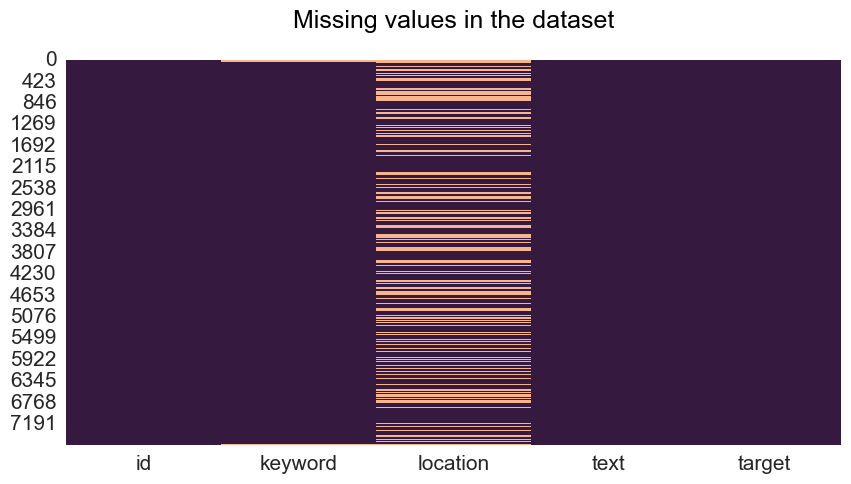

In [96]:
plt.figure(figsize=(10, 5))
sns.heatmap(df_train.isnull(), cbar=False, cmap=palette)
plt.title('Missing values in the dataset', fontdict=title_font)
plt.show()

On peut <u>**voir**</u> que la colonne "keyword" n'est pas renseiignée pour les premiers et derniers tweets du dataset.   
En revanche, la colonne "location" possède des valeurs manquantes sur l'ensemble du dataset.

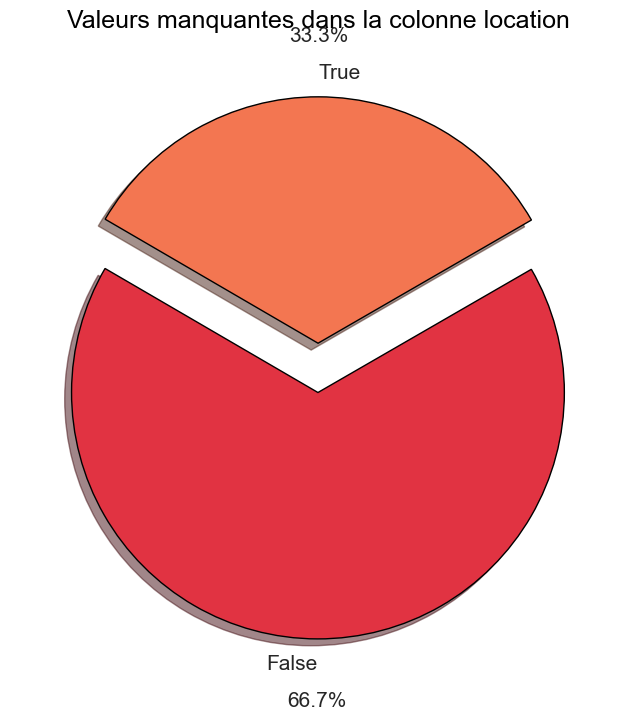

In [97]:
plt.figure(figsize=(10, 8))
df_train['location'].isnull().value_counts().plot.pie(autopct='%1.1f%%', colors=[redish, light], startangle=30, counterclock=False, explode=(0.1, 0.1), shadow=True, textprops={'fontsize': 15}, wedgeprops={'edgecolor': 'black'}, rotatelabels=False, pctdistance=1.25)
plt.title('Valeurs manquantes dans la colonne location', fontdict=title_font)
plt.ylabel('')
plt.show()

On <u>**remarque**</u> que la colonne "location" est vide à 33%.

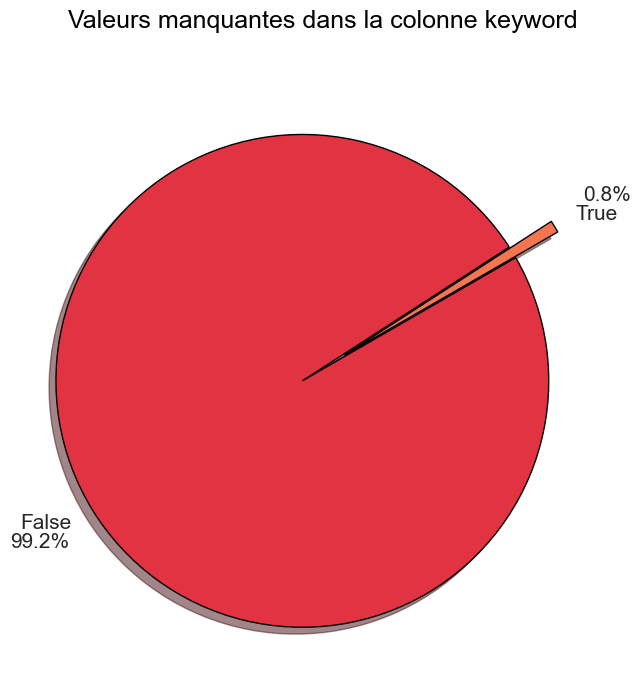

In [98]:
plt.figure(figsize=(10, 8))
df_train['keyword'].isnull().value_counts().plot.pie(autopct='%1.1f%%', colors=[redish, light], startangle=30, counterclock=False, explode=(0.1, 0.1), shadow=True, textprops={'fontsize': 15}, wedgeprops={'edgecolor': 'black'}, rotatelabels=False, pctdistance=1.25)
plt.title('Valeurs manquantes dans la colonne keyword', fontdict=title_font)
plt.ylabel('')
plt.show()

La colonne "keyword" est vide à 0.8%.

C:\Users\x_mat\AppData\Local\Temp\ipykernel_9764\3089041087.py:4: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.barplot(hue=not_null.index, y=not_null, ax=ax[0], palette=palette, legend=False)
C:\Users\x_mat\AppData\Local\Temp\ipykernel_9764\3089041087.py:5: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.barplot(hue=null.index, y=null, ax=ax[1], palette=palette, legend=False)


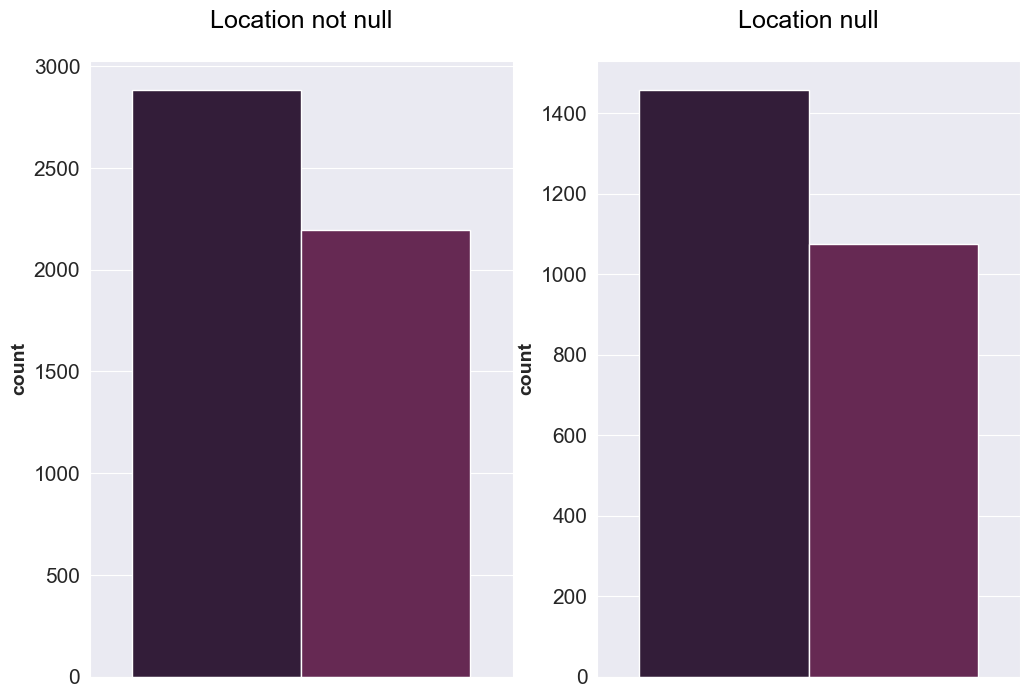

In [99]:
not_null = df_train[df_train['location'].notnull()]['target'].value_counts()
null = df_train[df_train['location'].isnull()]['target'].value_counts()
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
sns.barplot(hue=not_null.index, y=not_null, ax=ax[0], palette=palette, legend=False)
sns.barplot(hue=null.index, y=null, ax=ax[1], palette=palette, legend=False)
ax[0].set_title('Location not null', fontdict=title_font)
ax[1].set_title('Location null', fontdict=title_font)
plt.show()

Vérifions les <U>**doublons**</u>.

In [100]:
df_train['text'].duplicated().sum()

110

In [101]:
tweet_length = df_train[df_train['text'].duplicated()]['text'].apply(len)

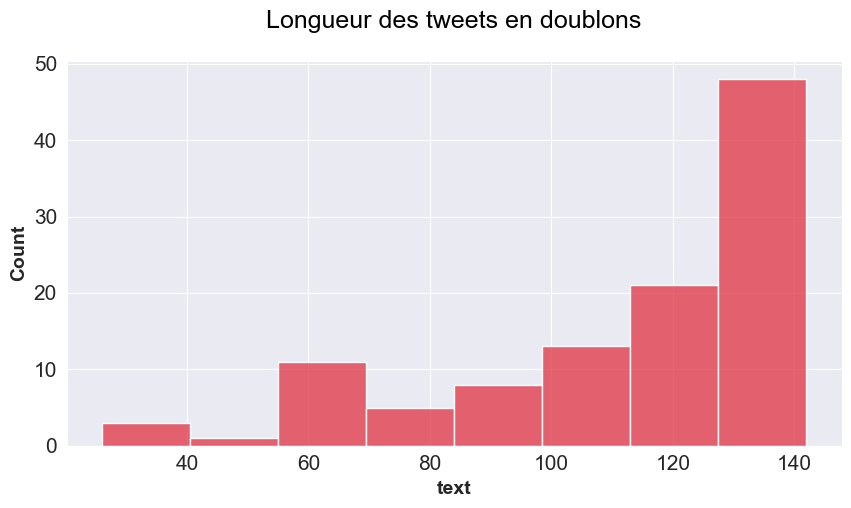

In [102]:
plt.figure(figsize=(10, 5))
sns.histplot(tweet_length, color=redish)
plt.title('Longueur des tweets en doublons', fontdict=title_font)
plt.show()

In [103]:
df_train['text'].duplicated().sum()

110

Nous <u>**choississons**</u> de supprimer les doublons.

In [104]:
df_train.drop_duplicates(subset='text', keep='first', inplace=True)

In [105]:
df_train.describe()

,id,target
count,7503.000000,7503.000000
mean,5439.831401,0.426230
std,3141.748725,0.494561
min,1.000000,0.000000
25%,2726.500000,0.000000
50%,5408.000000,0.000000
75%,8149.500000,1.000000
max,10873.000000,1.000000


Si nous supprimons les lignes ayant des valeurs nulles alors -> suppresion d'un tiers des données.   
Drop des colonnes ou remplacement par des valeurs par défaut ?

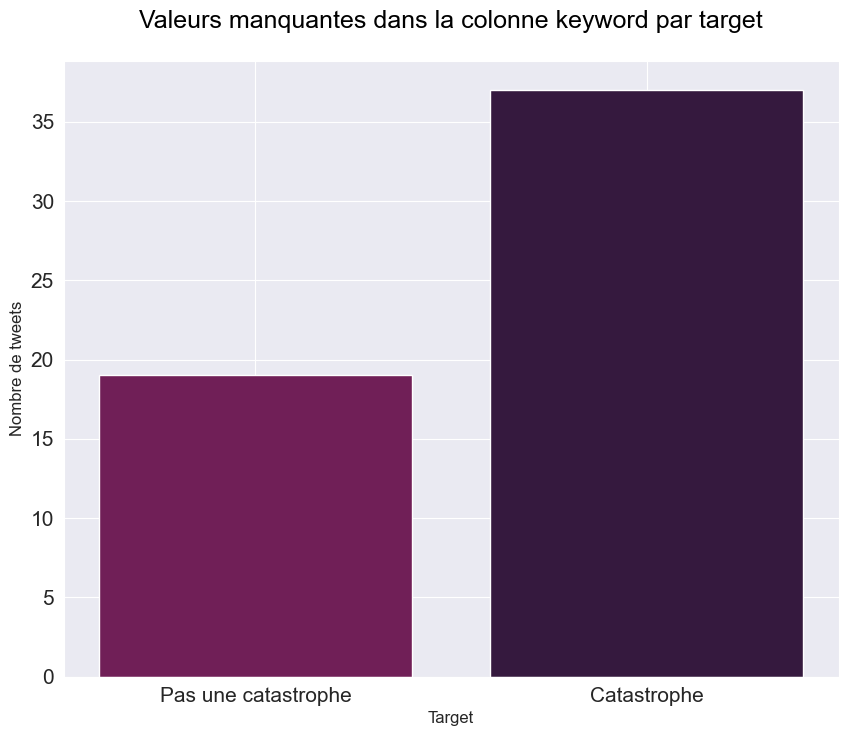

In [106]:
plt.figure(figsize=(10, 8))
plt.bar(df_train[df_train['keyword'].isnull()]['target'].value_counts().index, df_train[df_train['keyword'].isnull()]['target'].value_counts(), color=palette)
plt.title('Valeurs manquantes dans la colonne keyword par target', fontdict=title_font)
plt.xlabel('Target', fontdict=label_font)
plt.ylabel('Nombre de tweets', fontdict=label_font)
plt.xticks([0, 1], ['Pas une catastrophe', 'Catastrophe'])
plt.show()

Il manque deux fois plus de mots clés pour les catastrophes que pour les tweets ne concernant pas des catastrophes.

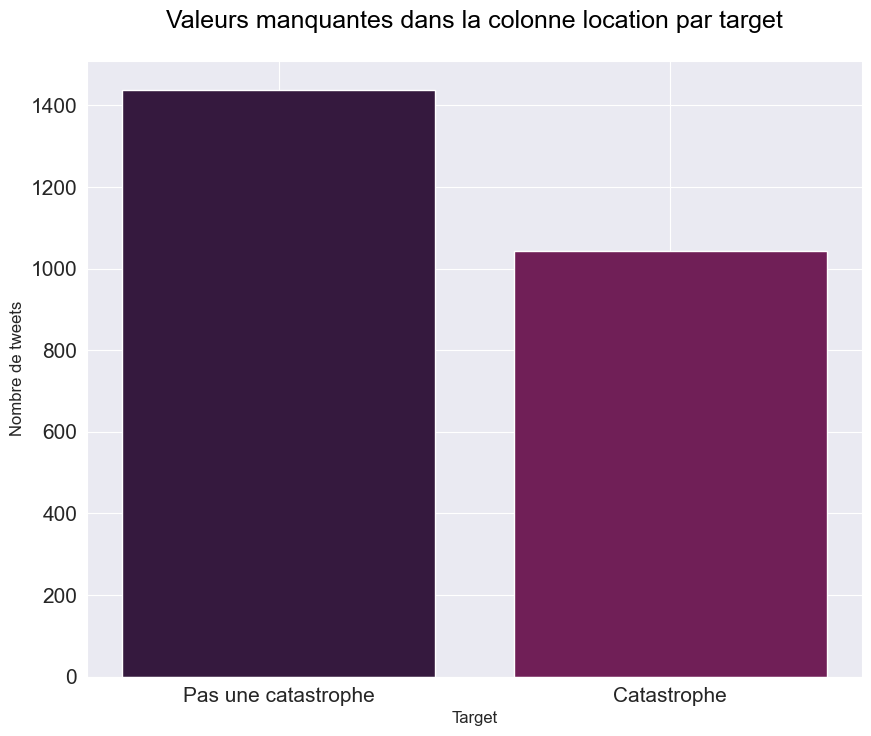

In [107]:
plt.figure(figsize=(10, 8))
plt.bar(df_train[df_train['location'].isnull()]['target'].value_counts().index, df_train[df_train['location'].isnull()]['target'].value_counts(), color=palette)
plt.title('Valeurs manquantes dans la colonne location par target', fontdict=title_font)
plt.xlabel('Target', fontdict=label_font)
plt.ylabel('Nombre de tweets', fontdict=label_font)
plt.xticks([0, 1], ['Pas une catastrophe', 'Catastrophe'])
plt.show()

La localisation des tweets est moins renseignée pour les tweets qui ne sont pas des catastrophes.

La localisation des tweets n'est pas une information pertinente pour la prédiction de la cible. Nous allons donc supprimer cette colonne.

In [108]:
df_train.drop(columns='location', inplace=True)

In [109]:
df_train.isnull().sum()

id          0
keyword    56
text        0
target      0
dtype: int64

Nous allons maintenant remplacer les valeurs manquantes de la colonne "keyword" par "unknown".

In [110]:
df_train.fillna({'keyword': 'unknown'}, inplace=True)

## <u style="color: blue">3. Analyse exploratoire</u>

### Néttoyage des données

In [111]:
# remove url with http, https, t.co
df_train['text'] = df_train['text'].str.replace(r'http\S+', '', regex=True).str.replace(r'https\S+', '', regex=True).str.replace(r'www\S+', '', regex=True).str.replace(r't.co\S+', '', regex=True)

# remove special characters, alone letters and numbers
df_train['text'] = df_train['text'].str.replace(r'[^a-zA-Z\s]', '', regex=True).str.replace(r'\b\w\b', '', regex=True).str.replace(r'\b\d+\b', '', regex=True)

### Nombre de stop words

Nous téléchargeons les stop words de la langue anglaise en utilisant la librairie nltk.

In [112]:
# download stopwords
nltk.download('stopwords')

# set stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\x_mat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


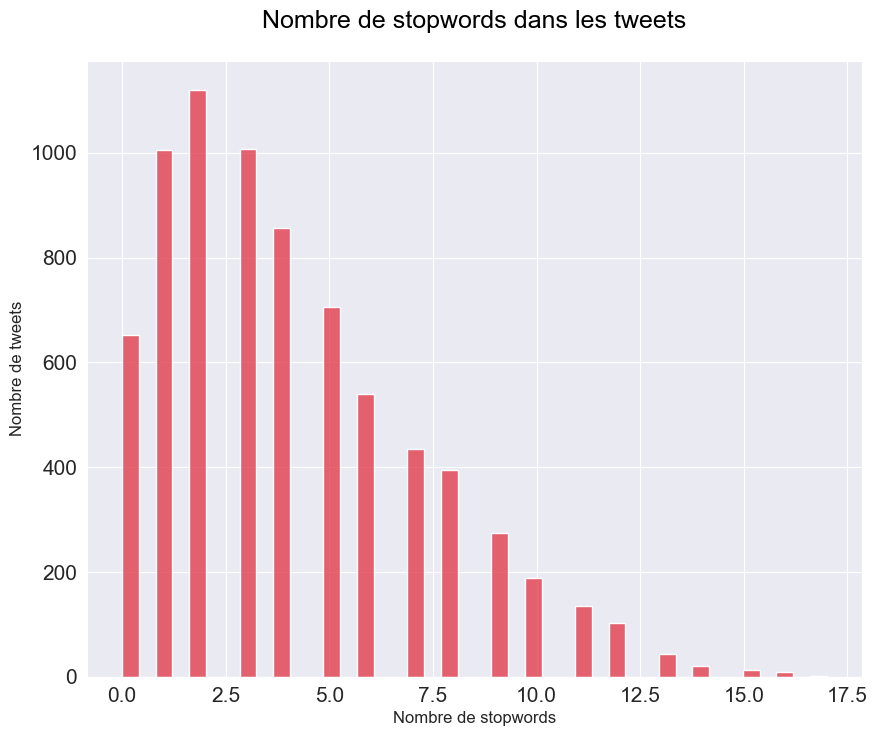

In [113]:
# count stopwords in each tweet
num_of_stop_words = df_train['text'].apply(lambda x: len([word for word in x.split() if word.lower() in stop_words]))

plt.figure(figsize=(10, 8))
sns.histplot(num_of_stop_words, color=redish)
plt.title('Nombre de stopwords dans les tweets', fontdict=title_font)
plt.xlabel('Nombre de stopwords', fontdict=label_font)
plt.ylabel('Nombre de tweets', fontdict=label_font)
plt.show()

### Nuage de mots

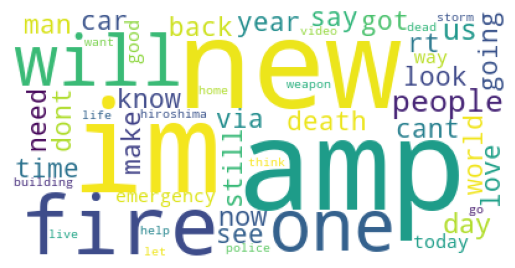

In [114]:
texte = ' '.join(df_train['text']).lower()
wordcloud = WordCloud(background_color = 'white', max_words = 50,).generate(texte)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Taille des tweets

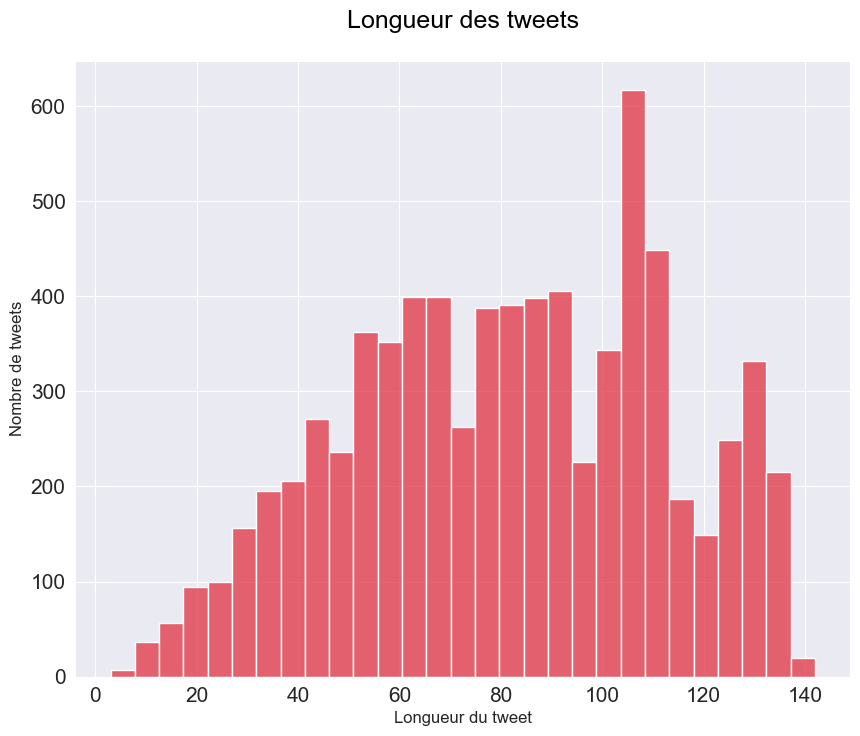

In [115]:
text_length = df_train['text'].apply(len)

plt.figure(figsize=(10, 8))
sns.histplot(text_length, color=redish)
plt.title('Longueur des tweets', fontdict=title_font)
plt.xlabel('Longueur du tweet', fontdict=label_font)
plt.ylabel('Nombre de tweets', fontdict=label_font)
plt.show()

### Nombre de mots par tweets

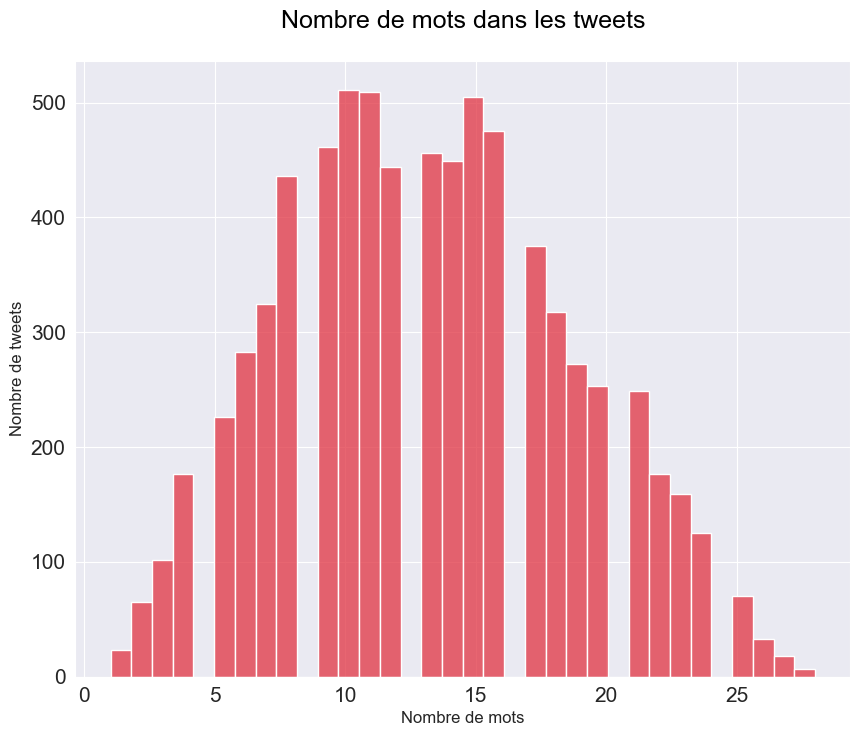

In [116]:
word_count = df_train['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 8))
sns.histplot(word_count, color=redish)
plt.title('Nombre de mots dans les tweets', fontdict=title_font)
plt.xlabel('Nombre de mots', fontdict=label_font)
plt.ylabel('Nombre de tweets', fontdict=label_font)
plt.show()

### Nombres de caractères par tweets

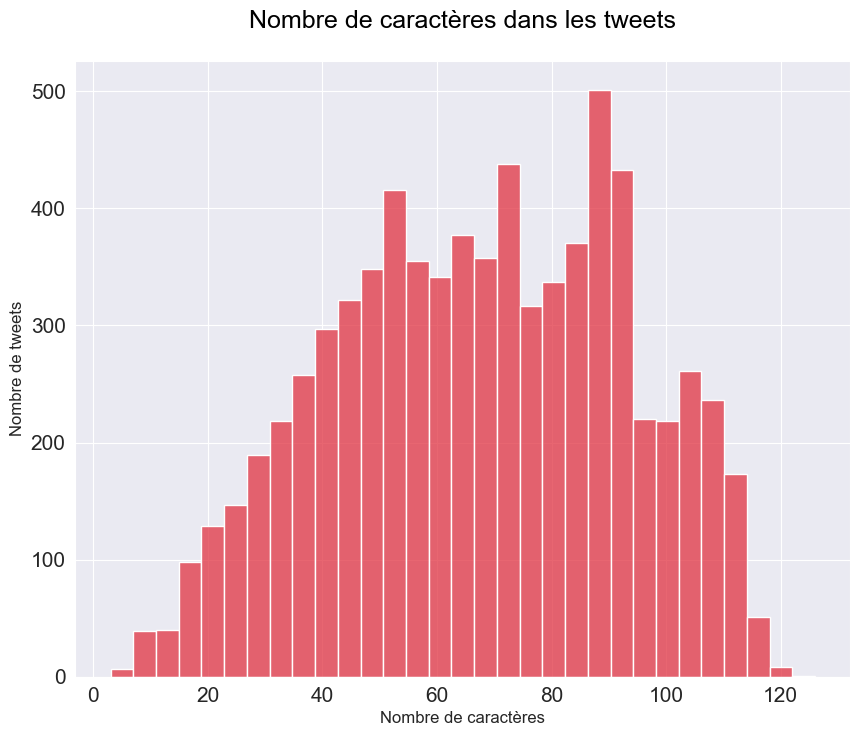

In [117]:
char_count = df_train['text'].apply(lambda x: len(x.replace(" ", "")))

plt.figure(figsize=(10, 8))
sns.histplot(char_count, color=redish)
plt.title('Nombre de caractères dans les tweets', fontdict=title_font)
plt.xlabel('Nombre de caractères', fontdict=label_font)
plt.ylabel('Nombre de tweets', fontdict=label_font)
plt.show()

C:\Users\x_mat\AppData\Local\Temp\ipykernel_9764\1397342308.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=df_train, palette=palette)
C:\Users\x_mat\AppData\Local\Temp\ipykernel_9764\1397342308.py:3: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.countplot(x='target', data=df_train, palette=palette)


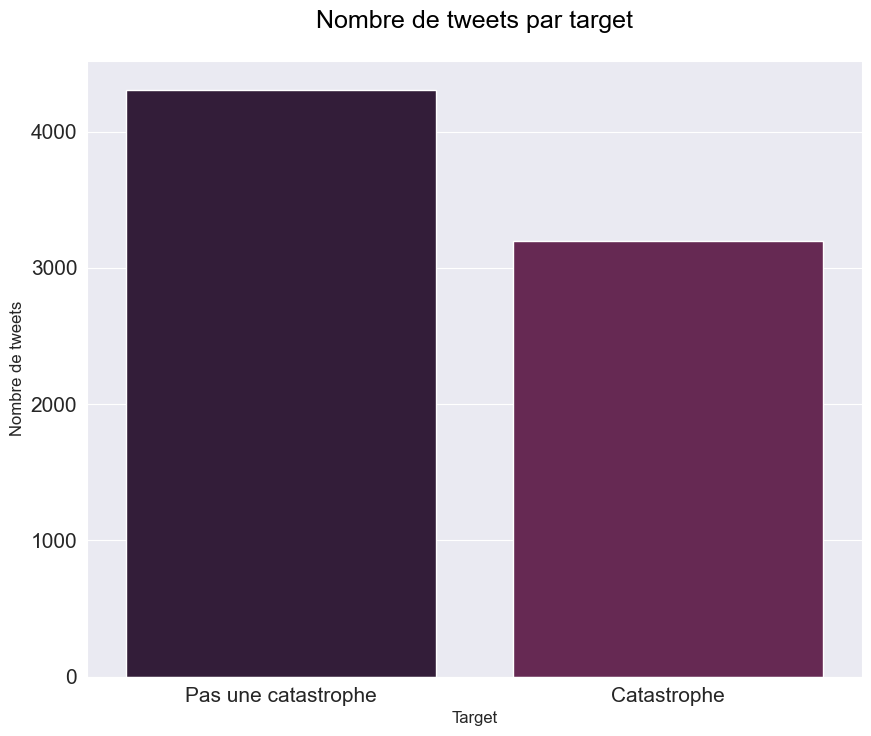

In [118]:
# number of target 1 vs 0
plt.figure(figsize=(10, 8))
sns.countplot(x='target', data=df_train, palette=palette)
plt.title('Nombre de tweets par target', fontdict=title_font)
plt.xlabel('Target', fontdict=label_font)
plt.ylabel('Nombre de tweets', fontdict=label_font)
plt.xticks([0, 1], ['Pas une catastrophe', 'Catastrophe'])
plt.show()

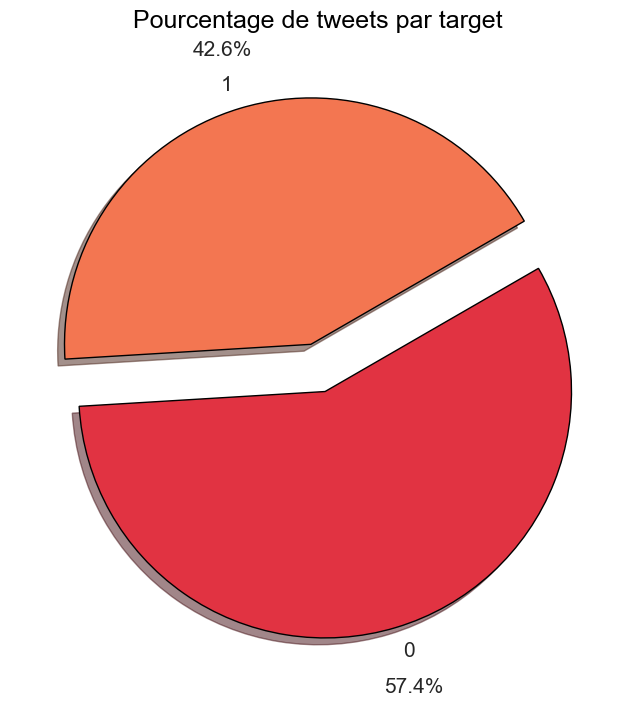

In [119]:
# pie plot percentage of target 1 vs 0
plt.figure(figsize=(10, 8))
df_train['target'].value_counts().plot.pie(autopct='%1.1f%%', colors=[redish, light], startangle=30, counterclock=False, explode=(0.1, 0.1), shadow=True, textprops={'fontsize': 15}, wedgeprops={'edgecolor': 'black'}, rotatelabels=False, pctdistance=1.25)
plt.title('Pourcentage de tweets par target', fontdict=title_font)
plt.ylabel('')
plt.show()

## <u style="color: blue">4. Préparation des données (Pipeline)</u>

Pour préparer nos données, je décide de boucler sur la colonne texte de faire des listes de mots, de les transformer en minuscules, de les tokeniser, de les lemmatiser et de les transformer en vecteurs.

Différence entre lemmatisation et stemming.

Stemming: méthode de normalisation de texte qui consiste à réduire les mots à leur racine ou à leur forme de base.   
Peut comporter des erreurs: plusieurs mots ayant des sens différents peuvent être réduits à la même racine: université, univers.

Lemmatisation: méthode de normalisation de texte qui consiste à réduire les mots à leur forme canonique.

In [120]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [139]:
# add words to stopwords
stop_words.update(['im', 'u', 'amp', 'get', 'dont', 'go', 'one', 'like', 'new', 'via', 'would', 'us', 'love', 'got', 'know', 'cant', 'still', 'back', 'see', 'day', 'time', 'make', 'good', 'think', 'really', 'even', 'well', 'much', 'want', 'need', 'way', 'look', 'right', 'take', 'thing', 'come', 'year', 'let', 'say', 'every', 'people', 'many', 'great', 'could', 'use', 'may', 'never', 'first', 'best', 'last', 'ever', 'live', 'always', 'next', 'big', 'find', 'feel', 'watch', 'rt', 'lol', 'youtube', 'video', 'youre', 'check', 'thats', 'ive', 'hes'])

In [140]:
# remove stop words from text
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

In [141]:
df_train['text']

0                   Deeds Reason earthquake ALLAH Forgive
1                   Forest fire near La Ronge Sask Canada
2       residents asked shelter place notified officer...
3          receive wildfires evacuation orders California
4       sent photo Ruby Alaska smoke wildfires pours s...
                              ...                        
7604    WorldNews Fallen powerlines Glink tram UPDATE ...
7605    flip side Walmart bomb everyone evacuate stay ...
7606    Suicide bomber kills Saudi security site mosqu...
7608    Two giant cranes holding bridge collapse nearb...
7612    Latest Homes Razed Northern California Wildfir...
Name: text, Length: 7503, dtype: object

In [142]:
df_train['transformed_text'] = df_train['text'].apply(lambda x: x.lower().split())

In [143]:
df_train['stemmed_text'] = df_train['transformed_text'].apply(lambda x: [PorterStemmer().stem(word) for word in x])

df_train.head(10)

,id,keyword,text,target,transformed_text,stemmed_text
0,1,unknown,Deeds Reason earthquake ALLAH Forgive,1,"[deeds, reason, earthquake, allah, forgive]","[deed, reason, earthquak, allah, forgiv]"
1,4,unknown,Forest fire near La Ronge Sask Canada,1,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, rong, sask, canada]"
2,5,unknown,residents asked shelter place notified officer...,1,"[residents, asked, shelter, place, notified, o...","[resid, ask, shelter, place, notifi, offic, ev..."
3,6,unknown,receive wildfires evacuation orders California,1,"[receive, wildfires, evacuation, orders, calif...","[receiv, wildfir, evacu, order, california]"
4,7,unknown,sent photo Ruby Alaska smoke wildfires pours s...,1,"[sent, photo, ruby, alaska, smoke, wildfires, ...","[sent, photo, rubi, alaska, smoke, wildfir, po..."
5,8,unknown,RockyFire Update California Hwy closed directi...,1,"[rockyfire, update, california, hwy, closed, d...","[rockyfir, updat, california, hwi, close, dire..."
6,10,unknown,flood disaster Heavy rain causes flash floodin...,1,"[flood, disaster, heavy, rain, causes, flash, ...","[flood, disast, heavi, rain, caus, flash, floo..."
7,13,unknown,top hill fire woods,1,"[top, hill, fire, woods]","[top, hill, fire, wood]"
8,14,unknown,Theres emergency evacuation happening building...,1,"[theres, emergency, evacuation, happening, bui...","[there, emerg, evacu, happen, build, across, s..."
9,15,unknown,afraid tornado coming area,1,"[afraid, tornado, coming, area]","[afraid, tornado, come, area]"


On récupère la racine des mots a l'aide de la stemmatisation.

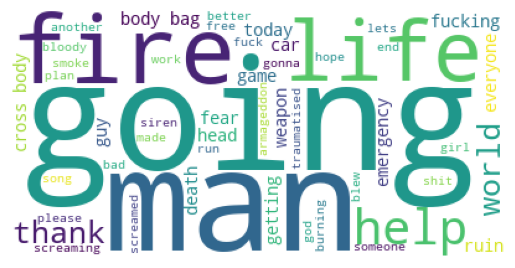

In [148]:
# cloud of words for target 0
texte = ' '.join(df_train[df_train['target'] == 0]['text']).lower()
wordcloud = WordCloud(background_color = 'white', max_words = 50,).generate(texte)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

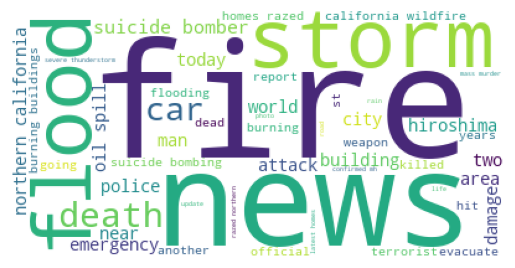

In [145]:
# cloud of words for target 1
texte = ' '.join(df_train[df_train['target'] == 1]['text']).lower()
wordcloud = WordCloud(background_color = 'white', max_words = 50,).generate(texte)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## <u style="color: blue">5. Adaptation de l'analyse exploratoire suite aux modifications</u>

## <u style="color: blue">6. Etudes des modèles d'apprentissage</u>

### 1. Modèle de régression logistique

### 2. Modèle de forêt aléatoire

### 3. Modèle d'arbres de décision

### 4. Modèle de XGBoost

### 5. Modèle de SVM